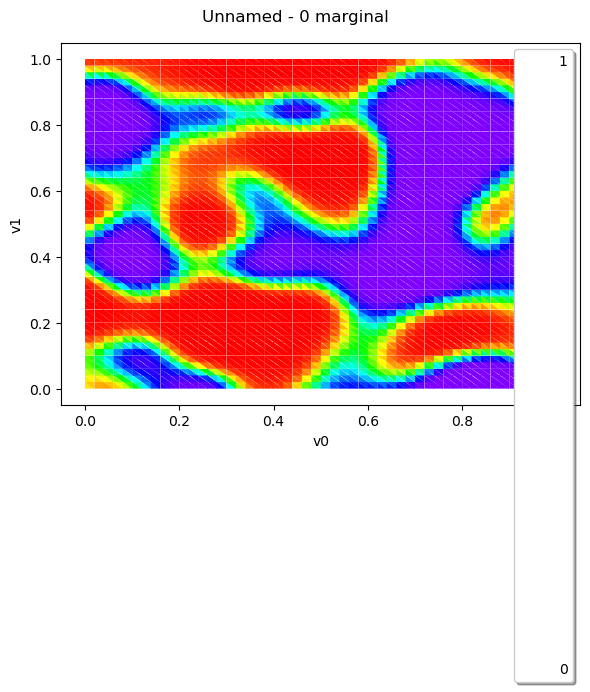

In [43]:
import openturns as ot
from openturns.viewer import View
import matplotlib.pyplot as plt

# (1)
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [1.0, 1.0]))

# (2)
cov = ot.SquaredExponential([0.1, 0.1], [4.5])
X = ot.GaussianProcess(cov, mesh)
field_X = X.getRealization()

# (3)
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
f = sigmoid(field_X)
field_f = ot.Field(mesh, f)

# Affichage 
graph = field_f.draw()
fig = plt.figure(figsize=(6, 6))
View(graph, figure=fig)
plt.tight_layout()
plt.show()


In [44]:
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

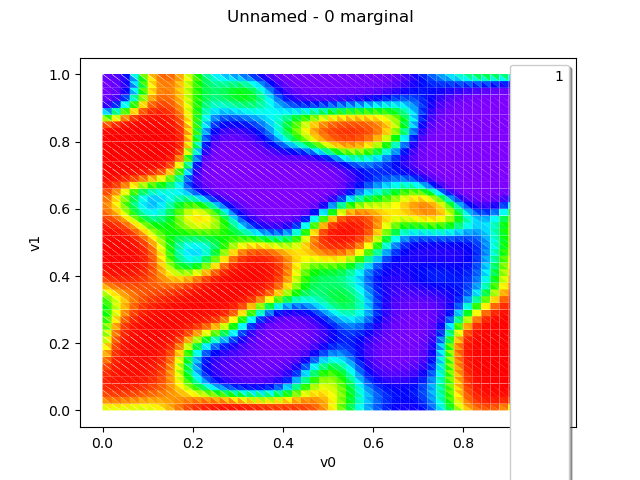

In [45]:
process.getRealization().draw()

In [46]:
process_sample = process.getSample(50)


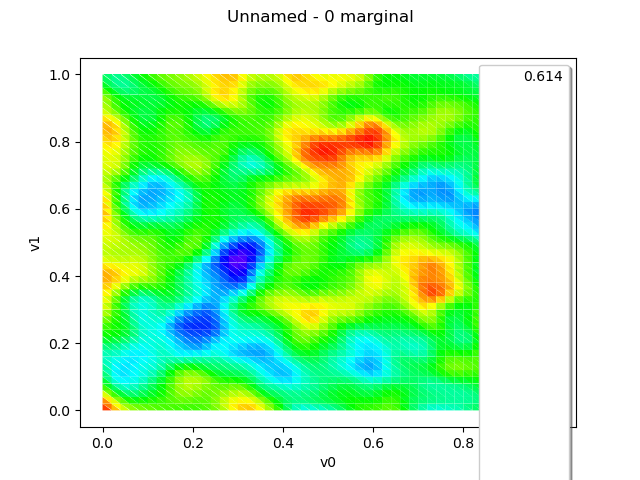

In [47]:
process_sample.computeMean().draw()

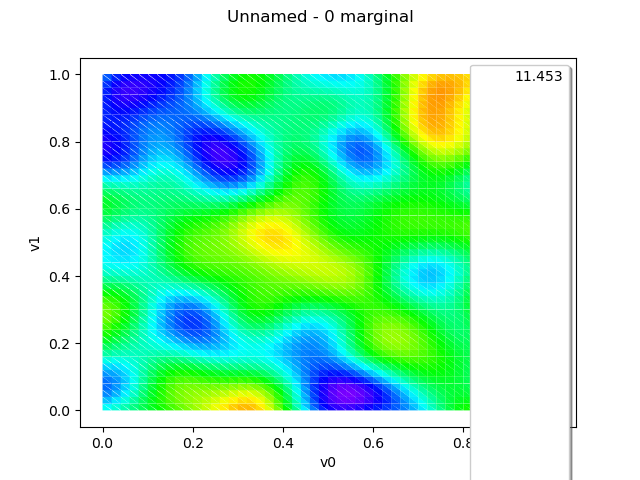

In [50]:
X.getRealization().draw()

(<Figure size 800x600 with 2 Axes>, <Axes: >)

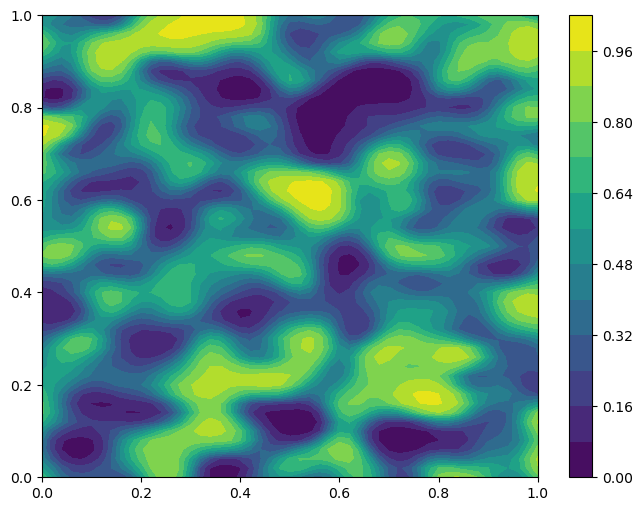

In [ ]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np

def plot_field(field):
    mesh = field.getMesh()
    # Get x, y, z values for matplotlib
    x = mesh.getVertices().getMarginal(0)
    y = mesh.getVertices().getMarginal(1)
    z = field.getValues()

    # Determine grid dimensions
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    nx = len(x_unique) # Number of points in x direction
    ny = len(y_unique) # Number of points in y direction

    # Reshape into 2D grids
    X = np.array(x).reshape(ny, nx)
    Y = np.array(y).reshape(ny, nx)
    Z = np.array(z).reshape(ny, nx)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create contour plot
    contour = ax.contourf(X, Y, Z, levels=15)
    fig.colorbar(contour, ax=ax)
    #ax.set_title("Contour Plot")
    #ax.set_xlabel("X")
    #ax.set_ylabel("Y")

    return fig, ax

# Create mesh
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [1.0, 1.0]))

# Create Gaussian process
cov = ot.SquaredExponential([0.06, 0.04], [1.5])
X = ot.GaussianProcess(cov, mesh)

# Create composite process sigmoid ° GP
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

# Plot a realization of the composite process
field_f = process.getRealization()
plot_field(field_f)

